<span style="font-size:150%">라이브러리</span>

In [1]:
import os,sys
sys.path.append(os.path.abspath('./../'))

import torch
import torchvision
import torchvision.models.detection as detection
from torch.utils.data import DataLoader
import coco.transforms as T
from coco.engine import train_one_epoch
from coco.utils import * 
from datasets import PennFudanDataset

import matplotlib.pyplot as plt
import cv2
%matplotlib inline

<span style="font-size:150%">경로 및 파라미터 설정</span>

In [2]:
data_path = './data/PennFudanPed'
save_path = './parameters'
num_epoch = 10

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

<span style="font-size:150%">어그멘테이션 설정</span>

In [3]:
def get_transform(train):
    transforms = []
    transforms.append(T.PILToTensor())
    transforms.append(T.ConvertImageDtype(torch.float))
    if train:
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

<span style="font-size:150%">데이터셋</span>

In [4]:
trainset = PennFudanDataset(data_path, get_transform(train=True))
testset = PennFudanDataset(data_path, get_transform(train=False))

indices = [i for i in range(len(trainset))]
dataset = torch.utils.data.Subset(trainset, indices[:-1])
dataset_test = torch.utils.data.Subset(testset, indices[-1:])

trainLoader = DataLoader(dataset, batch_size=1, shuffle=True, collate_fn=collate_fn)
testLoader = DataLoader(dataset_test, batch_size=1, shuffle=False, collate_fn=collate_fn)

<span style="font-size:150%">모델 선언</span>

In [5]:
backbone = detection.backbone_utils.resnet_fpn_backbone(backbone_name='resnet50', weights=None)

anchor_generator = detection.rpn.AnchorGenerator(sizes=((32,), (64,), (128,), (256,), (512,),),
                                                 aspect_ratios=((0.5, 1.0, 2.0),)*5)

roi_pooler = torchvision.ops.MultiScaleRoIAlign(featmap_names=['0', '1', '2', '3'],
                                                output_size=7,
                                                sampling_ratio=2)

weight = torch.load(os.path.join(save_path, 'resnet50.pth'))
backbone.body.load_state_dict(weight, strict=False)

model = detection.FasterRCNN(backbone,
                   num_classes=2,
                   rpn_anchor_generator=anchor_generator,
                   box_roi_pool=roi_pooler)
model = model.to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, weight_decay=0.0005)

<span style="font-size:150%">모델 학습</span>

In [6]:
for epoch in range(num_epoch):
    train_one_epoch(model, optimizer, trainLoader, device, epoch, print_freq=10)
torch.save(model.state_dict(), os.path.join(save_path, 'detector.pth'))

Epoch: [0]  [  0/169]  eta: 0:05:41  lr: 0.000069  loss: 1.2563 (1.2563)  loss_classifier: 0.5213 (0.5213)  loss_box_reg: 0.0028 (0.0028)  loss_objectness: 0.6904 (0.6904)  loss_rpn_box_reg: 0.0418 (0.0418)  time: 2.0220  data: 0.0179  max mem: 1273
Epoch: [0]  [ 10/169]  eta: 0:00:48  lr: 0.000664  loss: 1.0711 (1.0836)  loss_classifier: 0.3760 (0.3681)  loss_box_reg: 0.0006 (0.0008)  loss_objectness: 0.6856 (0.6844)  loss_rpn_box_reg: 0.0266 (0.0303)  time: 0.3050  data: 0.0097  max mem: 1384
Epoch: [0]  [ 20/169]  eta: 0:00:31  lr: 0.001259  loss: 0.8226 (0.9120)  loss_classifier: 0.1394 (0.2327)  loss_box_reg: 0.0005 (0.0014)  loss_objectness: 0.6560 (0.6509)  loss_rpn_box_reg: 0.0219 (0.0270)  time: 0.1191  data: 0.0088  max mem: 1384
Epoch: [0]  [ 30/169]  eta: 0:00:24  lr: 0.001853  loss: 0.7253 (0.8701)  loss_classifier: 0.1152 (0.2187)  loss_box_reg: 0.0025 (0.0244)  loss_objectness: 0.5648 (0.6015)  loss_rpn_box_reg: 0.0213 (0.0254)  time: 0.1032  data: 0.0090  max mem: 1384


<span style="font-size:150%">모델 출력 시각화</span>

In [7]:
imgs, targets= next(iter(testLoader))
img = imgs[0]
sample = img.permute(1,2,0).cpu().numpy()
target = targets[0]
boxes = target['boxes'].cpu().numpy().astype(int)
print(boxes)

[[  5  37 101 323]
 [100  25 205 322]]


In [8]:
model.eval()
device = torch.device('cpu')
model = model.to(device)
outputs = model(img.unsqueeze(0))
outputs = [{k: v.to(device) for k, v in t.items()} for t in outputs]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([  5,  39,  98, 323], dtype=torch.int32) tensor(0.9837, grad_fn=<UnbindBackward0>)
tensor([104,  18, 208, 328], dtype=torch.int32) tensor(0.9584, grad_fn=<UnbindBackward0>)
tensor([  4,  38,  49, 313], dtype=torch.int32) tensor(0.3297, grad_fn=<UnbindBackward0>)
tensor([ 59,  52, 234, 262], dtype=torch.int32) tensor(0.2485, grad_fn=<UnbindBackward0>)
tensor([118, 123, 188, 327], dtype=torch.int32) tensor(0.2094, grad_fn=<UnbindBackward0>)
tensor([149,  53, 217, 258], dtype=torch.int32) tensor(0.1506, grad_fn=<UnbindBackward0>)
tensor([ 94,  40, 174, 275], dtype=torch.int32) tensor(0.1477, grad_fn=<UnbindBackward0>)
tensor([ 64,  64, 132, 241], dtype=torch.int32) tensor(0.1033, grad_fn=<UnbindBackward0>)
tensor([  5, 154,  96, 300], dtype=torch.int32) tensor(0.0591, grad_fn=<UnbindBackward0>)


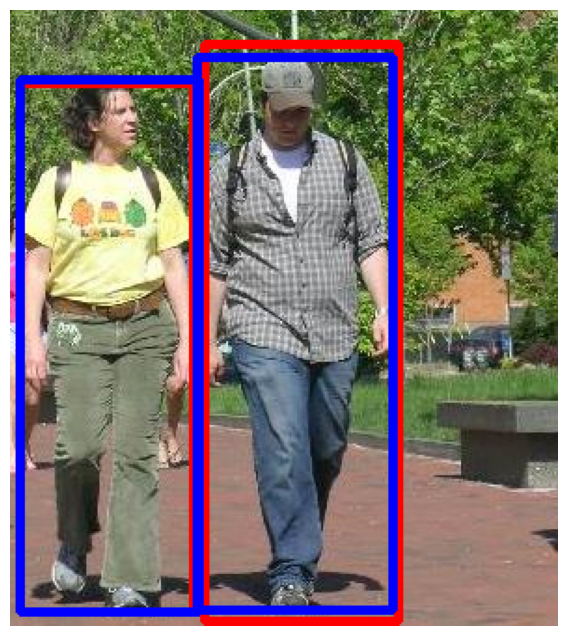

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(16, 8))

mean_score = torch.mean(outputs[0]['scores'])

for box, score in zip(outputs[0]['boxes'].int(), outputs[0]['scores']):
    print(box, score)
    if score > 0.5:
        cv2.rectangle(sample,(box[0].item(), box[1].item()),(box[2].item(), box[3].item()),(225, 0, 0), 3)
        
for box in zip(targets[0]['boxes'].int()):
    box = box[0]
    cv2.rectangle(sample,(box[0].item(), box[1].item()),(box[2].item(), box[3].item()),(0, 0, 255), 3)
    
ax.set_axis_off()
ax.imshow(sample)